# Optimisation de portefeuille à partir d'analyse de sentiment des news 

## Chargement des librairies

In [4]:
!pip install wordcloud
!pip install nltk
!pip install yfinance
!pip install plotly
!pip install pandas_datareader

     |████████████████████████████████| 363 kB 1.7 MB/s            
     |████████████████████████████████| 1.5 MB 1.7 MB/s            
     |████████████████████████████████| 763 kB 53.0 MB/s            
     |████████████████████████████████| 6.9 MB 8.0 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for multitasking: filename=multitasking-0.0.10-py3-none-any.whl size=8500 sha256=512e2cdd39ab1f6b5a148f82be1654a598743882df474c2e31d15ae56d4e015d
  Stored in directory: /home/jovyan/.cache/pip/wheels/f2/b5/2c/59ba95dcf854e542944c75fe3da584e4e3833b319735a0546c
Successfully built multitasking
     |████████████████████████████████| 26.5 MB 11.3 MB/s            
     |████████████████████████████████| 109 kB 1.5 MB/s            


In [5]:
import requests
from bs4 import BeautifulSoup
import pandas as pd


# Partie wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import urllib


# Partie NLP
import nltk

nltk.download('punkt')
words = nltk.download('stopwords')
nltk.download('vader_lexicon')

from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re

# Partie DataViz
import math
import seaborn as sns
import yfinance as yf
import datetime 

import plotly.graph_objects as go

# Partie modelisation/optmisation

from numpy import matrix, array, zeros, empty, sqrt, ones, dot, append, mean, cov, transpose, linspace

from numpy.linalg import inv, pinv

import pandas_datareader as pdr
from datetime import datetime
from pylab import *


import scipy.optimize
import random


[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jovyan/nltk_data...


## Webscrapping des titres de news

In [6]:
def get_company():

    """
    Cette fonction récupère une liste contenant le noms des différentes entreprises sur Investing.com 
    
    Sortie = liste des titres de news
    """
    
    url = 'https://fr.investing.com/indices/investing.com-us-500-components'
    r = requests.get(url, headers={"User-Agent": "Mozilla/5.0"}) #on utilise User agent pour faire croire au site que c'est un veritable utilisateur qui souhaite se connecter et pas un bot
    soup = BeautifulSoup(r.content, 'html.parser')
    tbody = soup.findAll("td",{"class":"bold left noWrap elp plusIconTd"})
    l = []
    for p in tbody:
        l.append(p.find("a")['href'].split('/')[2])
    return l

In [7]:
liste_entreprise = get_company()
#liste_entreprise

In [8]:
def get_news(company,nb_page=1):
    """
    Cette fonction permet de récupérer les titres des news associés à une compagnie sur une page donnée
    
    Entrée : 
    company = le nom de l'entreprise dont on souhaite obtenir les news (format = chaine de caractère). Elle doit correspondre à une page d'investing.com
    nb_page = numero de la page sur lesquels on souhaite retourner les news (1 page = 10 titres) (format = int), initialisé à 1
    
    Sortie:
    liste = liste de titre de news
    """

    url = 'https://www.investing.com/equities/'+company+'-news/'+str(nb_page)
    r = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})
    soup = BeautifulSoup(r.content, 'html.parser')
    article_body = soup.findAll("a",{"class":"title"})
    #print(article_body)
    l=[]
    for p in article_body:
        l.append(p.get("title"))
    return l[6:] #les 6 premiers titre son des pub (sur toute les pages...)

In [50]:
print(get_news("tesla-motors",3))

['Tesla recalls some model 3 and model S vehicles in China', "The Year of the Doge? 2021, crypto's wildest year yet", 'MicroStrategy Increased Its Bitcoin Holdings Once More', 'Lucid Stock Jumps After Citi Calls It a Buy, With 48% Potential Upside', 'Shiba Inu (SHIB) Plans Big Surprises for 2022', 'Micron, Tesla, Biogen Fall Premarket; Johnson & Johnson Rises', 'Tesla Trades Weaker on Recall of Certain Model 3 and S Cars', '2021: The Year in Review', 'Dow, S&P close at record highs as Omicron worries ease', "Tesla's Musk exercises all of his stock options expiring next year", 'Should you use a trading bot? The good, the bad, and the ugly of algorithmic trading.', 'Alvexo - Trading CFDs with Candlesticks', 'Alvexo - Non-Farm Payroll Report (NFP): Live Trading Event', 'Alvexo - Getting Started with Technical Analysis']


In [9]:
def get_tilte_dictionary(company_list, number_page=1):
    """
    Cette fonction permet de créer un dictionnaire en associant chaque companie avec ces news
    
    Entrée : 
    company_list = liste des noms d'entreprises dont on souhaite obtenir les news
    nb_page = nombre de pages sur lesquels on souhaite itérer
    
    Sortie:
    dictionnaire : clé = companie
                   valeur = texte contenant tout les titres
    """

    dicto = {}
    for company in company_list :
        l = []
        for page in range(1,number_page+1):
            l = l + get_news(company, page)
        dicto[str(company)] = ' '.join(l).lower()
    
    return dicto


## Word cloud 

In [56]:
data = get_tilte_dictionary(liste_entreprise[:100],1)

In [57]:
print(data['boeing-co'])

pre-market movers: tesla jumps, ford, boeing rise; ross stores dips jet maker safran plans 12,000 hires in 2022 as air traffic recovers israel signs deal to buy $3.1 billion in u.s. helicopters, tankers u.s. stocks mixed at close of trade; dow jones industrial average up 0.25% boeing 737 max to resume flights in indonesia – report s&p 500 ends lower after four-day rally to record high u.s. stocks mixed at close of trade; dow jones industrial average up 0.26% s&p 500 snaps record run after briefly topping 4,800 s&p 500 eases from record as tech stumble offsets rebound in travel stocks stocks making the biggest moves midday: coinbase, boeing, carnival and more should you use a trading bot? the good, the bad, and the ugly of algorithmic trading. alvexo - trading cfds with candlesticks alvexo - non-farm payroll report (nfp): live trading event alvexo - getting started with technical analysis


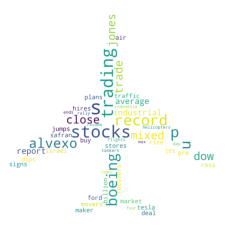

In [58]:
mask = np.array(Image.open(requests.get('https://www.freeiconspng.com/uploads/airplane-icon-image-gallery-1.png', stream=True).raw))

wordcloud = WordCloud(background_color = 'white', max_words = 50, mask  = mask).generate(data['boeing-co'])
plt.imshow(wordcloud)
plt.axis("off")
plt.show();

In [3]:
sns.histplot([len(i) for i in data['boeing-co'].split()  ])
plt.title('histogram de la longueur des mots pour les news de boeing')

NameError: name 'sns' is not defined

## NLP Analyse de sentiment

In [59]:
def clean_text(text):
    """
    Cette fonction permet de nettoyer les textes pour pouvoir les traiter et les analyser
    
    Entrée : 
    texte = texte brut contenant les titres des news associés à une compagnie
    
    Sortie:
    texte = texte modifié 
    """
    
    words = nltk.word_tokenize(text)
    
    words = [word for word in words if word.isalpha()]
    
    stop_words = set(stopwords.words('english'))
    keep_words = ['up', 'down', 'under','no'] #modifier cette liste ????
    stop_words = [word for word in stop_words if word not in keep_words]
    words = [ word for word in words if not word in stop_words]
    
    stemmer = SnowballStemmer(language = 'english')
    stemmed = [stemmer.stem(word) for word in words]
    
    return(' '.join(stemmed))

In [60]:
def return_sentiment(company_data):
    """
    Cette fonction permet de retourner l'analyse de sentiment à une compagnie donnée.
    
    Entrée : 
    company_data = texte de titre de news associé à une companie
    
    Sortie:
    texte = score d'analyse de sentiment avec des poids de 1.5 aux mots à connotation positive, 1 aux mots neutres et -1.5 pour les mots à connotation négatives. Ces poids ont étés choisi arbitrairement donc discutable.
    """
    
    text = clean_text(company_data)
    sid = SentimentIntensityAnalyzer()
    l = sid.polarity_scores(clean_text(company_data))
    return(l['pos']*1.5 + l['neu'] - l['neg']*1.5) #fonction faites à la main,à discuter

In [61]:
def build_data_sentiment(company_list, page=1):
    """
    Cette fonction permet de compiler toutes les fonctions précedemment définis. A partir d'une liste de compagnie, cette fonction retourne un dataframe avec deux colonnes les companies associés à leur score d'analyse de sentiment
    
    Entrée : 
    company_list = liste des noms d'entreprises dont on souhaite obtenir les news
    nb_page = nombre de pages sur lesquels on souhaite itérer
    
    Sortie:
    df = dataframe avec une colonne des compagnie et une colonne de score d'analyse de sentiment
    """
    data = get_tilte_dictionary(company_list, page)
    df = pd.DataFrame(columns = ['company','score'])
    for company in company_list : 
        df = df.append({'company': str(company), 'score':return_sentiment(data[company])},ignore_index=True)
    return df

In [62]:
df = build_data_sentiment(liste_entreprise,3) #surment un peu long pour le dataframe complet !!!

In [63]:
df = df.set_index('company')
ordered_df = df['score'].sort_values(ascending = False)

In [64]:
kept_company = ordered_df[:20]
print(kept_company)

company
signet-jewelers-limited     1.0240
cboe-holdings-inc           0.9690
hershey-co                  0.9675
pepsico                     0.9670
zions-bancorp               0.9665
nike                        0.9650
motorola-inc                0.9630
zoetis-inc                  0.9620
metlife-inc                 0.9585
waste-managemnt             0.9575
kohls-corp                  0.9550
eqt-corporation             0.9545
polo-ralph-laur             0.9540
kroger-co                   0.9525
eastman-chem                0.9520
essex-property-trust-inc    0.9515
pnc-fin-serv                0.9510
eaton                       0.9495
intuitive-surgical-inc      0.9495
te-connectivity             0.9465
Name: score, dtype: float64


## Data vizualiation avec Yahoo Finance

In [15]:
def get_tickers(company):
    
    """
    Cette fonction retourne le ticker d'une entreprise à partir de son nom sur investing
    
    Entrée:
    company : string contenant le nom de l'entreprise sur investing
    
    Sortie:
    ticker :  string contenant le ticker correspondant
    """
    
    url = 'https://www.investing.com/equities/'+company
    r = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})
    soup = BeautifulSoup(r.content, 'html.parser')
    article_body = soup.findAll("h1",{"class":"text-2xl font-semibold instrument-header_title__GTWDv mobile:mb-2"})
    #print(article_body)
    ticker = str(re.search(r'\((.*?)\)',str(article_body)).group(0) )
    ticker = re.search(r'[a-zA-Z]+',ticker ).group(0) 
    return ticker

In [16]:
def get_ticker_list(kept_company):
    
    """
    Cette fonction retourne la liste des tickers d'une entreprise à partir de son nom sur investing
    
    Entrée:
    kept_company: liste des compagnies gardées suite à l'analyse de sentiment contenant les noms des entreprises sur investing
    
    Sortie:
    liste :  liste contenant les tickers correspondant
    """
    
    l=[]
    for i in range(len(kept_company)):
        l.append(get_tickers(kept_company.index[i]))
    return l

In [67]:
#get_ticker_list(kept_company)

In [17]:
tickers = get_ticker_list(kept_company)

NameError: name 'kept_company' is not defined

In [18]:
def retrieve_ticker_name(tickers):
    
    """
    Cette fonction permet de retrouver les noms réels des compagnies à partir de la liste des tickers
    
    Entrée:
    tickers : liste des tickers des entreprises
    
    Sortie:
    liste :  liste contenant les noms réels des entreprises
    """
    
    l = []
    for i in tickers:
        stock = yf.Ticker(i)
        if stock.info['longName'] == None:
            l.append(i)
        else:
            l.append(stock.info['longName'])
    return(l)

ticker_name = retrieve_ticker_name(tickers)

NameError: name 'tickers' is not defined

In [19]:
def load_data(tickers, start = datetime.datetime(2012,5,31), end = datetime.datetime.now() ):
    
    """
    Cette fonction permet de charger les données financières associées aux tickers.
    
    Entrée:
    tickers : liste des tickers des entreprises
    start : date de début de la plage de temps choisie, initialisé au 31/05/2012
    end : date de fin de la plage de temps choisie, initialisé à la date d'aujourd'hui
    
    Sortie:
    df :  dataframe contenant les données financières associés aux différents tickers
    """
    
    df = yf.download(tickers, start, end, group_by="ticker") 
    #print(df)
    return(df)
    
data = load_data(tickers)

NameError: name 'tickers' is not defined

In [20]:
def keep_close(tickers, data):
    
    """
    Cette fonction permet de garder seulement les données financières de clôture des marchés (ajustées) associées aux tickers.
    
    Entrée:
    tickers : liste des tickers des entreprises
    data : dataframe contenant les données financières associés aux différents tickers
    
    Sortie:
    df :  dataframe contenant les données de clôture ajustées associés aux différents tickers
    """
    
    df = pd.DataFrame()
    for i in tickers:
        Close = data[i]["Adj Close"]
        df[i] = Close
    return df

data_close = keep_close(tickers, data)

NameError: name 'tickers' is not defined

In [21]:
df = data[tickers[0]]

fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df.Open,
                high=df.High,
                low=df.Low,
                close=df.Close)])

fig.update_layout(
    title=ticker_name[0]+' full stock price',
    yaxis_title="Price in $ USD")

fig.show()

NameError: name 'data' is not defined

In [13]:
def tendance(prix, window = 5):
    """
    cette fonction renvoie le mooving average du prix de cloture
    
    entrée :
    prix : prix de cloture
    window = fenêtre de calcul
    
    sortie:
    df : dataframe dont les colonnes sont: prix et mooving average
    """
    
    df = prix[:window]
    for i in range(window, len(prix) ):
        df.append( mean(prix[i-5,i]))
    return df

NameError: name 'data_close' is not defined

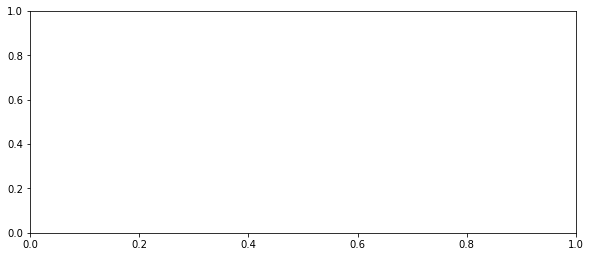

In [22]:
fig = plt.figure(figsize=(22, 50))
rows = 10
columns =2
grid = plt.GridSpec(rows, columns, wspace = .25, hspace = .25)
for i in range(rows*columns):
    exec (f"plt.subplot(grid{[i]})")
    plt.plot(data_close[tickers[i]])
    plt.plot(tendance(data_close[tickers[i]]), y=data_close.index , col)
    plt.title(ticker_name[i] +" stock price")
    plt.ylabel("Price in $ USD")

In [105]:
data_log_close = data_close.apply(np.log, axis=1)
data_return = data_log_close - data_log_close.shift(1)
data_return = data_return.iloc[1: , :]
corr = data_return.corr()
corr.style.background_gradient(cmap='coolwarm')

,SIG,CBOE,HSY,PEP,ZION,NKE,MSI,ZTS,MET,WM,KSS,EQT,RL,KR,EMN,ESS,PNC,ETN,ISRG,TEL
SIG,1.000000,0.271808,0.225912,0.212240,0.407543,0.319980,0.293403,0.220890,0.423262,0.300173,0.474198,0.248643,0.388545,0.126329,0.402691,0.300925,0.446599,0.415550,0.220331,0.434455
CBOE,0.271808,1.000000,0.354665,0.367920,0.314442,0.295176,0.314929,0.303931,0.352197,0.386668,0.214715,0.092177,0.214737,0.111161,0.268609,0.353414,0.405675,0.316573,0.250990,0.351379
HSY,0.225912,0.354665,1.000000,0.588930,0.200046,0.308422,0.339231,0.339546,0.304201,0.490335,0.171394,0.145279,0.184052,0.197967,0.296436,0.428154,0.345030,0.351759,0.283115,0.359124
PEP,0.212240,0.367920,0.588930,1.000000,0.266656,0.391858,0.422668,0.428199,0.423039,0.552145,0.205484,0.156547,0.272545,0.242751,0.344299,0.483077,0.405580,0.433312,0.341014,0.407550
ZION,0.407543,0.314442,0.200046,0.266656,1.000000,0.380504,0.391614,0.268710,0.749881,0.379814,0.463930,0.295663,0.492659,0.136848,0.598418,0.347132,0.811206,0.574846,0.286711,0.542237
NKE,0.319980,0.295176,0.308422,0.391858,0.380504,1.000000,0.404141,0.416398,0.459466,0.416288,0.346111,0.180730,0.443351,0.162224,0.411156,0.358678,0.452212,0.469219,0.373124,0.482668
MSI,0.293403,0.314929,0.339231,0.422668,0.391614,0.404141,1.000000,0.444616,0.464275,0.487043,0.299479,0.167215,0.350878,0.183407,0.438484,0.394369,0.472815,0.486407,0.398313,0.463090
ZTS,0.220890,0.303931,0.339546,0.428199,0.268710,0.416398,0.444616,1.000000,0.402170,0.437410,0.208467,0.182798,0.255075,0.132077,0.353978,0.357778,0.395427,0.442774,0.460256,0.460191
MET,0.423262,0.352197,0.304201,0.423039,0.749881,0.459466,0.464275,0.402170,1.000000,0.471287,0.464363,0.302790,0.517839,0.180827,0.658424,0.403469,0.788204,0.664354,0.390835,0.625908
WM,0.300173,0.386668,0.490335,0.552145,0.379814,0.416288,0.487043,0.437410,0.471287,1.000000,0.287196,0.175476,0.334389,0.186723,0.417787,0.497678,0.511130,0.509253,0.347137,0.469696


## Modélisation/Optimisation du portefeuille

In [150]:
def calcul_meanvar(names, prices, caps): #données entrée = noms action, prix de cloture (pas les return, on les recalcul dans la fonction), et le market cap
        """
        Cette fonction calcul les poids des entreprises, les rendements exponentiels, ainsi que les matrices de covariances
    
        Entrée:
        names : noms des entreprises
        prices : prix de clotûre des actions
        caps :  market cap
    
        Sortie:
        names : la même chose qu'en entrée
        weight :  liste des poids des entreprises en fonction de leurs market cap
        returns_exp : liste des moyennes des rendements exponentiel des prix de clotures
        covars : matrice de covariance des rendements expontentiels moyen
        """
        
        
        prices.dropna(axis=0,inplace=True)
        prices = matrix(prices).transpose()                     #matrice des prix
        weights = array(caps) / sum(caps)       # matrice des poids
        
        # matrice des rendements historiques
        rows, cols = prices.shape
        returns = empty([rows, cols-1])
        for r in range(rows):
                for c in range(cols-1):
                        p0, p1 = prices[r,c], prices[r,c+1]
                        returns[r,c] = (p1/p0)-1

        # calcul des rendements moyens
        returns_exp = array([])
        for r in range(rows):
                returns_exp = append(returns_exp, np.mean(returns[r]))
        # calcul des covariances
        covars = cov(returns)

        returns_exp = (1+returns_exp)**250-1      # on annualise les rendements (conpound interest
        covars = covars * 250                           # on annualise les covariances

        return names, weights, returns_exp, covars

#       rf (ou r)       taux sans risque (fixé arbitrairement)
#       C               matrice variance covariance  = covars
#       W               poids des actifs = weigth
#       R               rendements des actifs = returns_exp


In [128]:
from pandas_datareader import data
def temporary_market_cap(tickers): #fonction à la va vite pour tester le code et bien comprendre ce que renvoie la fonction précédente, en faire une plus propre pour le rendu final
    return list(data.get_quote_yahoo(tickers)['marketCap'])

In [129]:
def mean_ptf(W, R):    #calcul du rendement moyen du portefeuille
    return sum(R*W)

In [130]:
def var_ptf(W, C):     #calcul de la variance du portefeuille
    return np.dot(np.dot(W, C), W)

In [131]:
def fit_model(W, R, C, r=0.2):
    # pour un niveau donné de rendement, on calcule le portefeuille qui minimise la variance
    mean = mean_ptf(W, R)
    var = var_ptf(W, C)
    penalty = 50*abs(mean-r)
    return var + penalty 

In [132]:
def mean_ptf_var(W,R,C):
    return mean_ptf(W,R), var_ptf(W,C)

In [133]:
# Fonction qui construit la frontière efficiente de markowitz (ensemble des portefeuilles efficients
def build_frontier(R, C, rf= 0.2): #je mets 0.2 par defaut pour tester
    frontier_mean, frontier_var, frontier_weights = [], [], []
    n = len(R)      
    for r in linspace(min(R), max(R), num=20): 
        W = ones([n])/n # matrice initialisé des poids (poids équilibré entre tous les actifs au départs)               
        b_ = [(0,1) for i in range(n)]
        c_ = ({'type':'eq', 'fun': lambda W: sum(W)-1. }) # on restreint les poids à 100% du portefeuille
        optimized = scipy.optimize.minimize(fit_model, W, (R, C, r), method='SLSQP', constraints=c_, bounds=b_) # algo de minimisation
        #print(optimized)
        if not optimized.success:
            raise BaseException("bug opti")
        frontier_mean.append(r)                                                 
        frontier_var.append(var_ptf(optimized.x, C))
        frontier_weights.append(optimized.x)
    return array(frontier_mean), array(frontier_var), frontier_weights

In [134]:
#calcul du portefeuille optimal au sens de markowitz
def build_weights(R, C, rf):
        def fit_model(W, R, C, rf):
                mean, var = mean_ptf_var(W, R, C)      
                util = (mean - rf) / sqrt(var)         
                return 1/util                                       
        n = len(R)
        W = ones([n])/n     # matrice initialisée des poids (poids équilibrés entre tous les actifs au départs)               
        b_ = [(0.,1.) for i in range(n)]
        c_ = ({'type':'eq', 'fun': lambda W: sum(W)-1. })       # on restreint les poids à 100% du portefeuille
        optimized = scipy.optimize.minimize(fit_model, W, (R, C, rf), method='SLSQP', constraints=c_, bounds=b_)
        if not optimized.success:
                raise Exception("bug opti")
        return optimized.x

In [152]:
def ptf_optim(title, names, R, C, rf, color='green'):
        # optimisation du portefeuille
        W = build_weights(R, C, rf) 
        mean, var = mean_ptf_var(W, R, C)                                      
        f_mean, f_var, f_weights = build_frontier(R, C, rf)        

        # on affiche le point de variance minimale
        print(title)
        print_assets(names, W, R, C)
        n = len(names)
        scatter([C[i,i]**.5 for i in range(n)], R, marker='x',color=color)
        for i in range(n):                                                                       
                text(C[i,i]**.5, R[i], '  %s'%names[i], verticalalignment='center', color=color)
        scatter(var**.5, mean, marker='o', color=color)             
        plot(f_var**.5, f_mean, color=color)             
        xlabel('$\sigma$'), ylabel('$r$')
        plt.grid(True)

Infos actifs poids historique
Nom         Poids Rendements    Std    Correlations
Signet Jewelers Limited   0.4%  26.5%  60.3%    1.000 
Cboe Global Markets, Inc.   1.1%  20.8%  24.5%    0.259 1.000 
The Hershey Company   3.1%  15.4%  21.0%    0.205 0.346 1.000 
PepsiCo, Inc.  18.7%  15.3%  18.1%    0.198 0.363 0.591 1.000 
Zions Bancorporation, National Association   0.8%  19.3%  32.3%    0.410 0.311 0.192 0.258 1.000 
NIKE, Inc.  20.5%  28.2%  26.1%    0.321 0.293 0.318 0.399 0.381 1.000 
Motorola Solutions, Inc.   3.6%  24.4%  24.0%    0.287 0.313 0.340 0.425 0.389 0.410 1.000 
Zoetis Inc.   9.0%  30.5%  24.5%    0.211 0.300 0.336 0.426 0.263 0.412 0.443 1.000 
MetLife, Inc.   4.1%  15.9%  30.5%    0.423 0.350 0.298 0.420 0.754 0.471 0.466 0.400 1.000 
Waste Management, Inc.   5.4%  23.5%  18.0%    0.288 0.388 0.496 0.560 0.379 0.428 0.496 0.434 0.472 1.000 
Kohl's Corporation   0.5%  17.0%  47.5%    0.470 0.210 0.166 0.199 0.477 0.350 0.302 0.206 0.480 0.285 1.000 
EQT Corporation 

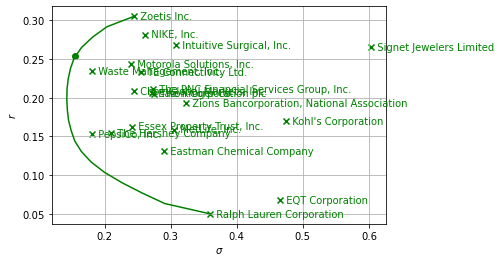

In [156]:
#### APPLICATION DE L'ENSEMBLE DES FONCTIONS PRECEDENTES POUR UNE ETUDE DE CAS
names, prices, caps = ticker_name, data_close, temporary_market_cap(tickers)
n = len(names) #chargement des données

# on calcule les rendements attendus et les covariances de nos actifs
names, W, R, C = calcul_meanvar(names, prices, caps)
rf = .025 #rendement actif sans risque

def print_assets(names, W, R, C):
        print("%-10s %6s %6s %6s %s" % ("Nom", "Poids", "Rendements", "Std", "   Correlations"))
        for i in range(len(names)):
                print("%-10s %5.1f%% %5.1f%% %5.1f%%    " % (names[i], 100*W[i], 100*R[i], 100*C[i,i]**.5), end='')
                for j in range(i+1):
                        corr = C[i,j] / (sqrt(C[i,i]) * (sqrt(C[j,j]))) # calcul des correlation à partir de la covariance
                        print("%.3f " % corr, end='')
                print()

print("Infos actifs poids historique")
print_assets(names, W, R, C)

# on calcule le rendement historique de notre portefeuille et sa variance
mean, var = mean_ptf_var(W, R, C)

# optimisation de notre portfeuille au sens de markowitz (maximise le ratio de sharpe) basé sur les prix historiques
ptf_optim("Optimisation au sens de Markowitz", names, R, C, rf, color='green')
show()